Strategy Summary:  
We use the LSTM model to predict the stock price of N day(s) after today. If the predicted price is higher than today's close price, then trade in with tomorrow's open price, and sell at the N day(s) after today's close price.

## Load Required Package

In [0]:
#import all libraries
import numpy as np
import pandas as pd
import math
import sklearn
import sklearn.preprocessing
from sklearn.preprocessing import MinMaxScaler
import datetime
import os
import matplotlib.pyplot as plt
import pandas_datareader.data as web
import seaborn as sns
import tensorflow.compat.v1 as tf
import tensorflow as tf

/Users/little/opt/anaconda3/lib/python3.7/site-packages/pandas_datareader/compat/__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


# Data Collection

In [0]:
def data_collection(ticker, start, end):
    
    df = web.get_data_yahoo(ticker, start, end)
    
    # Change all column headings to be lower case, and remove spacing
    df.columns = [str(x).lower().replace(' ', '_') for x in df.columns]

    return df

In [0]:
# import dataset 
df = data_collection('AAPL', datetime.date(2015,1,1), datetime.date(2020,5,1))
df = df.dropna()
df = df[['open', 'close', 'high', 'low', 'volume']]

print(df.shape)
df.head()

(1342, 5)


,open,close,high,low,volume
Date,,,,,
2015-01-02,111.389999,109.330002,111.440002,107.349998,53204600.0
2015-01-05,108.290001,106.250000,108.650002,105.410004,64285500.0
2015-01-06,106.540001,106.260002,107.430000,104.629997,65797100.0
2015-01-07,107.199997,107.750000,108.199997,106.699997,40105900.0
2015-01-08,109.230003,111.889999,112.150002,108.699997,59364500.0


# Data Preprocessing

In [0]:
# Use seq_length days to predict stock price after ‘day' day
seq_length = 30
day = 10
data_dim = 5
output_dim = 1

In [0]:
# Data Prepariation to 3D array
xy = df[['open', 'close', 'high', 'low', 'volume']] #extract features
xy = np.array(xy.values) #convert to array

# Data Range: 0 ~ length(df)-seq_length-day+1
dataXY = []
for i in range(0, len(xy) - seq_length - day + 1):
    _xy = xy[i:i + seq_length + day]
    dataXY.append(_xy)  
# reshape dataXY
dataXY = np.vstack(dataXY).reshape(-1, seq_length + day, data_dim)

# Predicted Price in 'day' days
app_dataX = []
for i in range(len(xy) - seq_length - day + 1, len(xy) - seq_length + 1):
    _x = xy[i:i + seq_length]
    app_dataX.append(_x)
# reshape app_dataX
app_dataX = np.vstack(app_dataX).reshape(-1, seq_length, data_dim)

print(dataXY.shape)
print(app_dataX.shape)

(1303, 40, 5)
(10, 30, 5)


In [0]:
# split to train and testing
train_size = int(len(dataXY) * 0.7)
test_size = len(dataXY) - train_size
xy_train, xy_test = np.array(dataXY[0:train_size]), np.array(dataXY[train_size:len(dataXY)])
print(xy_train.shape)
print(xy_test.shape)

(912, 40, 5)
(391, 40, 5)


In [0]:
# Scaled train data
scaler = MinMaxScaler()
xy_train = xy_train.reshape((-1, data_dim)) #transfer train data to 2D
xy_train_new = scaler.fit_transform(xy_train) #scale the train data by column, in each column, min=0, max=1
xy_train_new = xy_train_new.reshape((-1, seq_length + day, data_dim))  #transfer train data to 3D
    
trainX = xy_train_new[:,0:seq_length] #trainX is the stock price of each first seq_length days
trainY = xy_train_new[:,-1,1]  #trainY is the close price of each last day

print(trainX.shape)
print(trainY.shape)

(912, 30, 5)
(912,)


In [0]:
# Scaled test data
xy_test = xy_test.reshape((-1, data_dim))
xy_test_new = scaler.transform(xy_test) #use the scaler of train data to scale test data
xy_test_new = xy_test_new.reshape((-1, seq_length + day, data_dim))
    
testX = xy_test_new[:, 0:seq_length]
testY = xy_test_new[:, -1, 1]

print(testX.shape)
print(testY.shape)

(391, 30, 5)
(391,)


In [0]:
# Scale the last 'day' day stock price
x_app = app_dataX.reshape((-1, data_dim)) #transfer to 2D
appX = scaler.transform(x_app) #use the scaler of train data to scale app data
appX = appX.reshape((-1, seq_length, data_dim)) 
print(appX.shape)

(10, 30, 5)


In [0]:
# prices for calculating strategy's income
close_price = xy_test_new[:, seq_length - 1, 1] #close price of seq_length - 1 day
buy_price = xy_test_new[:, seq_length, 0] #open price of seq_length day
sell_price = xy_test_new[:, -1, 1] #close price of the last day

# Model

## Model1

Train Model

In [0]:
from keras.layers import Input, Dense, LSTM, Reshape
from keras.models import Model
from keras import regularizers, callbacks

def lstm1(code, day, trainX, trainY, seq_length, data_dim, output_dim):
    # 构建神经网络层 1层Dense层+1层LSTM层+4层Dense层
    rnn_units = 32
    Dense_input = Input(shape=(seq_length, data_dim), name='dense_input') #输入层
    #shape: 形状元组（整型）不包括batch size。表示了预期的输入将是一批（seq_len,data_dim）的向量。
    Dense_output_1 = Dense(rnn_units, activation='relu', kernel_regularizer=regularizers.l2(0.0), name='dense1')(Dense_input) #全连接网络

    lstm_input = Reshape(target_shape=(seq_length, rnn_units), name='reshape2')(Dense_output_1) 
    #改变Tensor形状，改变后是（None，seq_length, rnn_units）
    lstm_output = LSTM(rnn_units, activation='tanh', dropout=1.0, name='lstm')(lstm_input) #LSTM网络
    #units: Positive integer,dimensionality of the output space.
    #dropout: Float between 0 and 1. Fraction of the units to drop for the linear transformation of the inputs.
    
    
    Dense_input_2 = Reshape(target_shape=(rnn_units,), name='reshape3')(lstm_output) 
    #改变Tensor形状，改变后是（None，rnn_units）
    Dense_output_2 = Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.0), name='dense2')(Dense_input_2) #全连接网络
    Dense_output_3 = Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.0), name='dense3')(Dense_output_2) #全连接网络
    Dense_output_4 = Dense(16, activation='relu', kernel_regularizer=regularizers.l2(0.0), name='dense4')(Dense_output_3) #全连接网络
    predictions = Dense(output_dim, activation=None, kernel_regularizer=regularizers.l2(0.0), name='dense5')(Dense_output_4) #全连接网络

    model = Model(inputs=Dense_input, outputs=predictions)
    #This model will include all layers required in the computation of output given input.
    
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    #Configures the model for training.
    #optimizer: String (name of optimizer) or optimizer instance. See optimizers.
    #loss: String (name of objective function) or objective function.The loss value will be minimized by the model.
    #metrics: List of metrics to be evaluated by the model during training and testing. Typically you will use  metrics=['accuracy'].
    
    ES = callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='auto', baseline=None)
    
    model.fit(trainX, trainY, batch_size=256, epochs=400, verbose=0, callbacks=[ES], validation_split=0.1)
    #Trains the model for a given number of epochs (iterations on a dataset).
    #verbose: Integer. 0, 1, or 2. Verbosity mode. 0 = silent, 1 = progress bar, 2 = one line per epoch.
    
    # 保存模型
    #model.save(code + '(1)' + str(day) + '.h5')   # HDF5文件，pip install h5py
    
    return model


In [0]:
# Train the LSTM model
model = lstm1('AAPL', 10, trainX, trainY, seq_length=30, data_dim=5, output_dim=1)

### Result

In [0]:
# Fit the model on the test data
testPredict = model.predict(testX)
# Scale back the predicted price and the actual price
testPredict2 = testPredict * scaler.data_range_[:1] + scaler.data_min_[:1]
testY2 = testY * scaler.data_range_[:1] + scaler.data_min_[:1]

In [0]:
result = pd.DataFrame({'Prediction': testPredict2[:,0],'Close': testY2})
result.tail()

,Prediction,Close
386,218.568387,281.537483
387,219.883153,276.978223
388,221.361152,286.066915
389,222.246980,292.096205
390,222.506241,287.397929


In [0]:
rmse = ((result.Prediction - result.Close) ** 2).mean() ** 0.5
print('RMSE is: %.2f' %rmse)

RMSE is: 36.86


### Strategy

In [0]:
# Scale back the buy price & sell price
# close_price: for comparison with the predicted price
close_price2 = close_price * scaler.data_range_[:1] + scaler.data_min_[:1]
# purchase price: the open price of the no.seq_length day
buy_price2 = buy_price * scaler.data_range_[:1] + scaler.data_min_[:1]
# selling price: the close price of the no.(seq_length+day) day
sell_price2 = sell_price * scaler.data_range_[:1] + scaler.data_min_[:1]

In [0]:
count = 0 #count number of error which is smaller than 1%
correct = np.zeros(len(testPredict2)) #count the number of correct predicting the trend
model_income = 0 #count the gain of the strategy
trade = 0 #number of trading days
tolerance = 1

for i in range(len(testY2)):
    #count number of error which is smaller than 1%
    if abs(testPredict2[i] - testY2[i]) / testY2[i] * 100 <= tolerance:
        count += 1
    #count the number of correct predicting the trend
    if np.sign(testPredict2[i] - close_price2[i]) == np.sign(testY2[i] - close_price2[i]):
        correct[i] = 1
    #if the predicted price of 'day'th day is higher than today's close price, then trade in
    if testPredict2[i] > close_price2[i]:
        model_income = model_income + sell_price2[i] - buy_price2[i]
        trade += 1
        
print('Model Income:', model_income)
print('Number of Smaller than 1% Error:', count)
print('Number of Days:', len(close_price2))
print('Number of Trading days:', trade)
print('Number of Correct Predicting Trend:', correct.sum())

Model Income: -50.542980576113536
Number of Smaller than 1% Error: 13
Number of Days: 391
Number of Trading days: 70
Number of Correct Predicting Trend: 133.0


In [0]:
# The latest 10 days' prediction
appPredict = model.predict(appX)
# Scale back & reshape
appPredict2 = appPredict * scaler.data_range_[:1] + scaler.data_min_[:1]
appPredict2 = appPredict2.reshape(-1)

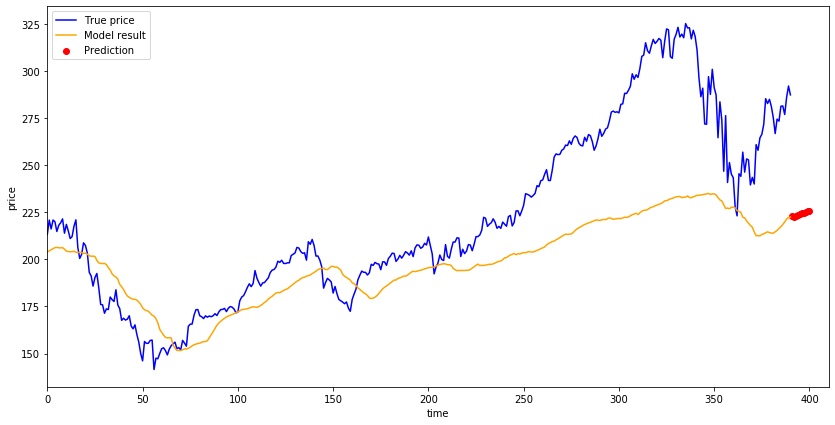

In [0]:
visual_window = 400
plt.figure(figsize=(14,7))
plt.scatter(
        list(range(len(testPredict2), len(testPredict2) + len(appPredict2))), appPredict2, color='red')  
plt.plot(list(range(len(testY2))), testY2, color='blue')
plt.plot(list(range(len(testPredict2))), testPredict2, color='orange')
  
plt.xlim((0, visual_window + day))
plt.legend(['True price', 'Model result', 'Prediction'], loc='upper left')
plt.ylabel('price')
plt.xlabel('time')
plt.show()

## Model2

### Train the model

In [0]:
from keras.models import Sequential
# parameters
epochs = 400
batch_size = 256
# LSTM parameters: return_sequences=True - the output of LSTM is a sequence; False，the output of LSTM is a number
# input_dim：dimension of input data
# input_length：time length of input data
model = Sequential()
model.add(LSTM(units=100, return_sequences=True, input_dim=trainX.shape[-1], input_length=trainX.shape[1]))
model.add(LSTM(units=50))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=epochs, batch_size=batch_size, verbose=1)

/Users/little/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
  if __name__ == '__main__':
/Users/little/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(units=100, return_sequences=True, input_shape=(30, 5))`
  if __name__ == '__main__':


Epoch 1/400
912/912 [==============================] - 1s 1ms/step - loss: 0.0935
Epoch 2/400
912/912 [==============================] - 1s 578us/step - loss: 0.0272
Epoch 3/400
912/912 [==============================] - 1s 554us/step - loss: 0.0067
Epoch 4/400
912/912 [==============================] - 1s 548us/step - loss: 0.0122
Epoch 5/400
912/912 [==============================] - 1s 558us/step - loss: 0.0040
Epoch 6/400
912/912 [==============================] - 1s 554us/step - loss: 0.0051
Epoch 7/400
912/912 [==============================] - 1s 580us/step - loss: 0.0038
Epoch 8/400
912/912 [==============================] - 0s 529us/step - loss: 0.0031
Epoch 9/400
912/912 [==============================] - 1s 554us/step - loss: 0.0035
Epoch 10/400
912/912 [==============================] - 1s 583us/step - loss: 0.0027
Epoch 11/400
912/912 [==============================] - 0s 527us/step - loss: 0.0029
Epoch 12/400
912/912 [==============================] - 0s 530us/step - loss

912/912 [==============================] - 0s 541us/step - loss: 0.0023
Epoch 98/400
912/912 [==============================] - 0s 522us/step - loss: 0.0023
Epoch 99/400
912/912 [==============================] - 0s 521us/step - loss: 0.0022
Epoch 100/400
912/912 [==============================] - 0s 507us/step - loss: 0.0022
Epoch 101/400
912/912 [==============================] - 0s 547us/step - loss: 0.0022
Epoch 102/400
912/912 [==============================] - 0s 535us/step - loss: 0.0022
Epoch 103/400
912/912 [==============================] - 0s 530us/step - loss: 0.0023
Epoch 104/400
912/912 [==============================] - 0s 526us/step - loss: 0.0023
Epoch 105/400
912/912 [==============================] - 0s 530us/step - loss: 0.0023
Epoch 106/400
912/912 [==============================] - 0s 523us/step - loss: 0.0022
Epoch 107/400
912/912 [==============================] - 0s 526us/step - loss: 0.0023
Epoch 108/400
912/912 [==============================] - 0s 537us/step

912/912 [==============================] - 1s 575us/step - loss: 0.0020
Epoch 193/400
912/912 [==============================] - 1s 572us/step - loss: 0.0020
Epoch 194/400
912/912 [==============================] - 1s 648us/step - loss: 0.0020
Epoch 195/400
912/912 [==============================] - 1s 1ms/step - loss: 0.0020
Epoch 196/400
912/912 [==============================] - 1s 930us/step - loss: 0.0021
Epoch 197/400
912/912 [==============================] - 1s 816us/step - loss: 0.0020
Epoch 198/400
912/912 [==============================] - 1s 917us/step - loss: 0.0020
Epoch 199/400
912/912 [==============================] - 1s 636us/step - loss: 0.0021
Epoch 200/400
912/912 [==============================] - 1s 567us/step - loss: 0.0021
Epoch 201/400
912/912 [==============================] - 1s 597us/step - loss: 0.0020
Epoch 202/400
912/912 [==============================] - 1s 705us/step - loss: 0.0020
Epoch 203/400
912/912 [==============================] - 1s 810us/step

912/912 [==============================] - 0s 522us/step - loss: 0.0019
Epoch 288/400
912/912 [==============================] - 0s 493us/step - loss: 0.0019
Epoch 289/400
912/912 [==============================] - 0s 506us/step - loss: 0.0019
Epoch 290/400
912/912 [==============================] - 0s 521us/step - loss: 0.0019
Epoch 291/400
912/912 [==============================] - 0s 539us/step - loss: 0.0019
Epoch 292/400
912/912 [==============================] - 0s 529us/step - loss: 0.0019
Epoch 293/400
912/912 [==============================] - 0s 516us/step - loss: 0.0019
Epoch 294/400
912/912 [==============================] - 0s 511us/step - loss: 0.0019
Epoch 295/400
912/912 [==============================] - 0s 512us/step - loss: 0.0019
Epoch 296/400
912/912 [==============================] - 0s 507us/step - loss: 0.0018
Epoch 297/400
912/912 [==============================] - 0s 501us/step - loss: 0.0018
Epoch 298/400
912/912 [==============================] - 0s 510us/st

912/912 [==============================] - 0s 516us/step - loss: 0.0017
Epoch 383/400
912/912 [==============================] - 0s 501us/step - loss: 0.0017
Epoch 384/400
912/912 [==============================] - 0s 521us/step - loss: 0.0016
Epoch 385/400
912/912 [==============================] - 0s 515us/step - loss: 0.0016
Epoch 386/400
912/912 [==============================] - 0s 504us/step - loss: 0.0016
Epoch 387/400
912/912 [==============================] - 0s 504us/step - loss: 0.0016
Epoch 388/400
912/912 [==============================] - 0s 510us/step - loss: 0.0015
Epoch 389/400
912/912 [==============================] - 0s 515us/step - loss: 0.0015
Epoch 390/400
912/912 [==============================] - 0s 503us/step - loss: 0.0016
Epoch 391/400
912/912 [==============================] - 0s 513us/step - loss: 0.0015
Epoch 392/400
912/912 [==============================] - 0s 499us/step - loss: 0.0015
Epoch 393/400
912/912 [==============================] - 1s 581us/st

### Result

In [0]:
# Fit the model on the test data
testPredict = model.predict(testX)
# Scale back the predicted price and the actual price
testPredict2 = testPredict * scaler.data_range_[:1] + scaler.data_min_[:1]
testY2 = testY * scaler.data_range_[:1] + scaler.data_min_[:1]

In [0]:
result = pd.DataFrame({'Prediction': testPredict2[:,0],'Close': testY2})
result.tail()

,Prediction,Close
386,246.153561,281.537483
387,250.373298,276.978223
388,253.017179,286.066915
389,255.003044,292.096205
390,255.514215,287.397929


In [0]:
rmse = ((result.Prediction - result.Close) ** 2).mean() ** 0.5
print('RMSE is: %.2f' %rmse)

RMSE is: 19.91


### Strategy

In [0]:
# Scale back the buy price & sell price
# close_price: for comparison with the predicted price
close_price2 = close_price * scaler.data_range_[:1] + scaler.data_min_[:1]
# purchase price: the open price of the no.seq_length day
buy_price2 = buy_price * scaler.data_range_[:1] + scaler.data_min_[:1]
# selling price: the close price of the no.(seq_length+day) day
sell_price2 = sell_price * scaler.data_range_[:1] + scaler.data_min_[:1]

In [0]:
count = 0 #count number of error which is smaller than 1%
correct = np.zeros(len(testPredict2)) #count the number of correct predicting the trend
model_income = 0 #count the gain of the strategy
trade = 0 #number of trading days
tolerance = 1

for i in range(len(testY2)):
    #count number of error which is smaller than 1%
    if abs(testPredict2[i] - testY2[i]) / testY2[i] * 100 <= tolerance:
        count += 1
    #count the number of correct predicting the trend
    if np.sign(testPredict2[i] - close_price2[i]) == np.sign(testY2[i] - close_price2[i]):
        correct[i] = 1
    #if the predicted price of 'day'th day is higher than today's close price, then trade in
    if testPredict2[i] > close_price2[i]:
        model_income = model_income + sell_price2[i] - buy_price2[i]
        trade += 1
        
print('Model Income:', model_income)
print('Number of Smaller than 1% Error:', count)
print('Number of Days:', len(close_price2))
print('Number of Trading days:', trade)
print('Number of Correct Predicting Trend:', correct.sum())

Model Income: 64.76477558520503
Number of Smaller than 1% Error: 33
Number of Days: 391
Number of Trading days: 209
Number of Correct Predicting Trend: 190.0


In [0]:
# The latest 10 days' prediction
appPredict = model.predict(appX)
# Scale back & reshape
appPredict2 = appPredict * scaler.data_range_[:1] + scaler.data_min_[:1]
appPredict2 = appPredict2.reshape(-1)

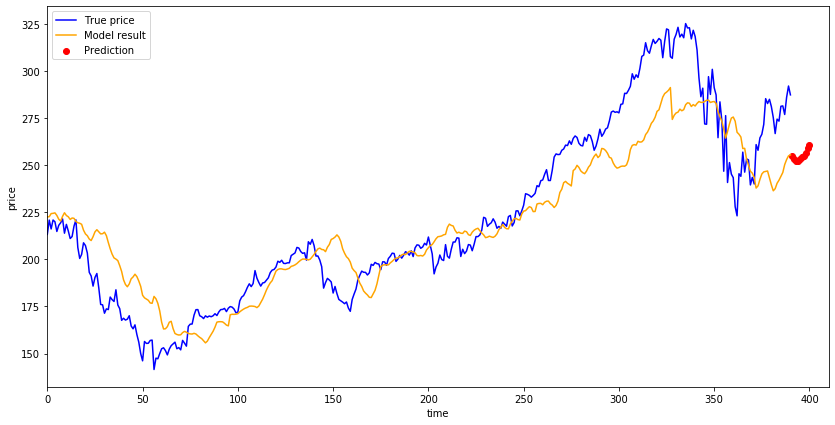

In [0]:
visual_window = 400
plt.figure(figsize=(14,7))
plt.scatter(
        list(range(len(testPredict2), len(testPredict2) + len(appPredict2))), appPredict2, color='red')  
plt.plot(list(range(len(testY2))), testY2, color='blue')
plt.plot(list(range(len(testPredict2))), testPredict2, color='orange')
  
plt.xlim((0, visual_window + day))
plt.legend(['True price', 'Model result', 'Prediction'], loc='upper left')
plt.ylabel('price')
plt.xlabel('time')
plt.show()

## Model3

### Data preprocessing

In [0]:
# Use seq_length days to predict stock price after ‘day' day
seq_length = 30
day = 10
data_dim = 5
output_dim = 1

In [0]:
# Train-test split
train = df[0:int(len(df)*0.7) + seq_length]
test = df[int(len(df)*0.7) - seq_length:]
print(train.shape)
print(test.shape)
train.head()

(969, 5)
(433, 5)


,open,close,high,low,volume
Date,,,,,
2015-01-02,111.389999,109.330002,111.440002,107.349998,53204600.0
2015-01-05,108.290001,106.250000,108.650002,105.410004,64285500.0
2015-01-06,106.540001,106.260002,107.430000,104.629997,65797100.0
2015-01-07,107.199997,107.750000,108.199997,106.699997,40105900.0
2015-01-08,109.230003,111.889999,112.150002,108.699997,59364500.0


In [0]:
# Standardization
scaler = MinMaxScaler(feature_range=(0, 1))  
scaled_data = scaler.fit_transform(train)
x_train, y_train = [], []

# Scale the train data
for i in range(seq_length, len(train)):
    x_train.append(scaled_data[i - seq_length:i-1])
    y_train.append(scaled_data[i, 1])
x_train, y_train = np.array(x_train), np.array(y_train)

print(x_train.shape)
print(y_train.shape)

(939, 29, 5)
(939,)


In [0]:
# Scale the test data
scaled_data = scaler.transform(test)
x_test, y_test = [], []

for i in range(seq_length, len(test)):
    x_test.append(scaled_data[i - seq_length:i-1])
    y_test.append(scaled_data[i, 1])
x_test, y_test = np.array(x_test), np.array(y_test)

print(x_test.shape)
print(y_test.shape)

(403, 29, 5)
(403,)


In [0]:
# prices for calculating strategy's income
close_price = x_test[:, -1, 1] #close price of No.seq_length-1 day

# open price of No.seq_length day
buy_price = []
for i in range(seq_length, len(test)):
    buy_price.append(scaled_data[i, 0])
buy_price = np.array(buy_price)

# close price of No.seq_length day
sell_price = y_test

### Train Model

In [0]:
from keras.models import Sequential
# parameters
epochs = 400
batch_size = 256
# LSTM parameters: return_sequences=True - the output of LSTM is a sequence; False，the output of LSTM is a number
# input_dim：dimension of input data
# input_length：time length of input data
model = Sequential()
model.add(LSTM(units=100, return_sequences=True, input_dim=x_train.shape[-1], input_length=x_train.shape[1]))
model.add(LSTM(units=50))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1)

/Users/little/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
  if __name__ == '__main__':
/Users/little/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(units=100, return_sequences=True, input_shape=(29, 5))`
  if __name__ == '__main__':


Epoch 1/400
939/939 [==============================] - 1s 1ms/step - loss: 0.0519
Epoch 2/400
939/939 [==============================] - 1s 546us/step - loss: 0.0204
Epoch 3/400
939/939 [==============================] - 0s 532us/step - loss: 0.0075
Epoch 4/400
939/939 [==============================] - 1s 533us/step - loss: 0.0084
Epoch 5/400
939/939 [==============================] - 0s 529us/step - loss: 0.0023
Epoch 6/400
939/939 [==============================] - 1s 543us/step - loss: 0.0042
Epoch 7/400
939/939 [==============================] - 1s 557us/step - loss: 0.0018
Epoch 8/400
939/939 [==============================] - 0s 513us/step - loss: 0.0026
Epoch 9/400
939/939 [==============================] - 0s 505us/step - loss: 0.0017
Epoch 10/400
939/939 [==============================] - 0s 506us/step - loss: 0.0017
Epoch 11/400
939/939 [==============================] - 0s 519us/step - loss: 0.0016
Epoch 12/400
939/939 [==============================] - 0s 506us/step - loss

939/939 [==============================] - 0s 504us/step - loss: 9.5745e-04
Epoch 97/400
939/939 [==============================] - 0s 496us/step - loss: 9.0917e-04
Epoch 98/400
939/939 [==============================] - 0s 492us/step - loss: 8.8391e-04
Epoch 99/400
939/939 [==============================] - 0s 500us/step - loss: 8.7245e-04
Epoch 100/400
939/939 [==============================] - 0s 492us/step - loss: 8.7444e-04
Epoch 101/400
939/939 [==============================] - 0s 497us/step - loss: 8.8026e-04
Epoch 102/400
939/939 [==============================] - 0s 508us/step - loss: 8.7692e-04
Epoch 103/400
939/939 [==============================] - 0s 505us/step - loss: 8.6498e-04
Epoch 104/400
939/939 [==============================] - 0s 493us/step - loss: 8.6705e-04
Epoch 105/400
939/939 [==============================] - 0s 488us/step - loss: 8.6407e-04
Epoch 106/400
939/939 [==============================] - 0s 495us/step - loss: 8.6492e-04
Epoch 107/400
939/939 [====

939/939 [==============================] - 0s 503us/step - loss: 6.6110e-04
Epoch 188/400
939/939 [==============================] - 0s 504us/step - loss: 6.7201e-04
Epoch 189/400
939/939 [==============================] - 0s 497us/step - loss: 6.3938e-04
Epoch 190/400
939/939 [==============================] - 0s 494us/step - loss: 6.3338e-04
Epoch 191/400
939/939 [==============================] - 0s 498us/step - loss: 6.2448e-04
Epoch 192/400
939/939 [==============================] - 0s 496us/step - loss: 6.1709e-04
Epoch 193/400
939/939 [==============================] - 0s 511us/step - loss: 6.2977e-04
Epoch 194/400
939/939 [==============================] - 0s 510us/step - loss: 6.6180e-04
Epoch 195/400
939/939 [==============================] - 0s 491us/step - loss: 7.1358e-04
Epoch 196/400
939/939 [==============================] - 0s 511us/step - loss: 6.5346e-04
Epoch 197/400
939/939 [==============================] - 0s 500us/step - loss: 6.3755e-04
Epoch 198/400
939/939 [=

939/939 [==============================] - 0s 514us/step - loss: 5.0838e-04
Epoch 279/400
939/939 [==============================] - 0s 508us/step - loss: 5.0709e-04
Epoch 280/400
939/939 [==============================] - 0s 494us/step - loss: 5.1305e-04
Epoch 281/400
939/939 [==============================] - 0s 501us/step - loss: 5.1058e-04
Epoch 282/400
939/939 [==============================] - 0s 502us/step - loss: 5.2154e-04
Epoch 283/400
939/939 [==============================] - 0s 511us/step - loss: 5.6812e-04
Epoch 284/400
939/939 [==============================] - 0s 500us/step - loss: 5.1727e-04
Epoch 285/400
939/939 [==============================] - 0s 504us/step - loss: 5.2015e-04
Epoch 286/400
939/939 [==============================] - 0s 491us/step - loss: 5.5719e-04
Epoch 287/400
939/939 [==============================] - 1s 572us/step - loss: 5.2634e-04
Epoch 288/400
939/939 [==============================] - 0s 492us/step - loss: 5.4217e-04
Epoch 289/400
939/939 [=

939/939 [==============================] - 0s 511us/step - loss: 4.7123e-04
Epoch 370/400
939/939 [==============================] - 0s 508us/step - loss: 4.7186e-04
Epoch 371/400
939/939 [==============================] - 0s 493us/step - loss: 4.7123e-04
Epoch 372/400
939/939 [==============================] - 0s 505us/step - loss: 4.7269e-04
Epoch 373/400
939/939 [==============================] - 0s 510us/step - loss: 4.8660e-04
Epoch 374/400
939/939 [==============================] - 0s 493us/step - loss: 5.0830e-04
Epoch 375/400
939/939 [==============================] - 0s 522us/step - loss: 4.8371e-04
Epoch 376/400
939/939 [==============================] - 0s 493us/step - loss: 4.6911e-04
Epoch 377/400
939/939 [==============================] - 0s 523us/step - loss: 5.0570e-04
Epoch 378/400
939/939 [==============================] - 0s 528us/step - loss: 5.2337e-04
Epoch 379/400
939/939 [==============================] - 0s 500us/step - loss: 5.5001e-04
Epoch 380/400
939/939 [=

### Result

In [0]:
# Fit the model on the test data
testPredict = model.predict(x_test)
# Scale back the predicted price and the actual price
testPredict2 = testPredict * scaler.data_range_[:1] + scaler.data_min_[:1]
testY2 = y_test * scaler.data_range_[:1] + scaler.data_min_[:1]

In [0]:
result = pd.DataFrame({'Prediction': testPredict2[:,0],'Close': testY2})
result.tail()

,Prediction,Close
398,268.968287,281.537483
399,272.760663,276.978223
400,275.077256,286.066915
401,274.783197,292.096205
402,277.693446,287.397929


In [0]:
rmse = ((result.Prediction - result.Close) ** 2).mean() ** 0.5
print('RMSE is: %.2f' %rmse)

RMSE is: 8.01


### Strategy

In [0]:
# Scale back the buy price & sell price
# close_price: for comparison with the predicted price
close_price2 = close_price * scaler.data_range_[:1] + scaler.data_min_[:1]
# purchase price: the open price of the no.seq_length day
buy_price2 = buy_price * scaler.data_range_[:1] + scaler.data_min_[:1]
# selling price: the close price of the no.(seq_length+day) day
sell_price2 = sell_price * scaler.data_range_[:1] + scaler.data_min_[:1]

In [0]:
count = 0 #count number of error which is smaller than 1%
correct = np.zeros(len(testPredict2)) #count the number of correct predicting the trend
model_income = 0 #count the gain of the strategy
trade = 0 #number of trading days
tolerance = 1

for i in range(len(testY2)):
    #count number of error which is smaller than 1%
    if abs(testPredict2[i] - testY2[i]) / testY2[i] * 100 <= tolerance:
        count += 1
    #count the number of correct predicting the trend
    if np.sign(testPredict2[i] - close_price2[i]) == np.sign(testY2[i] - close_price2[i]):
        correct[i] = 1
    #if the predicted price of 'day'th day is higher than today's close price, then trade in
    if testPredict2[i] > close_price2[i]:
        model_income = model_income + sell_price2[i] - buy_price2[i]
        trade += 1
        
print('Model Income:', model_income)
print('Number of Smaller than 1% Error:', count)
print('Number of Days:', len(close_price2))
print('Number of Trading days:', trade)
print('Number of Correct Predicting Trend:', correct.sum())

Model Income: -154.69086431205628
Number of Smaller than 1% Error: 102
Number of Days: 403
Number of Trading days: 188
Number of Correct Predicting Trend: 199.0


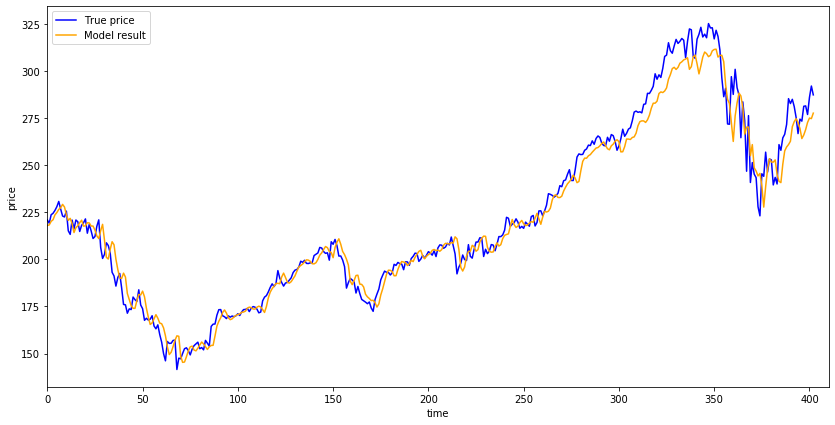

In [0]:
visual_window = 400
plt.figure(figsize=(14,7))
plt.plot(list(range(len(testY2))), testY2, color='blue')
plt.plot(list(range(len(testPredict2))), testPredict2, color='orange')
  
plt.xlim((0, visual_window + day))
plt.legend(['True price', 'Model result'], loc='upper left')
plt.ylabel('price')
plt.xlabel('time')
plt.show()